# Processing Pycontrol Data #

Here we take pycontrol files and convert them to a big pandas dataframe.
We then plot behavioural results using seaborn.

In [93]:
#Setup
import os 
import pandas as pd
import seaborn as sns
import numpy as np
import json

# MANUAL INPUT #
maze_config = 'FC' # 'FC','1', '2',
start_date = '2024-02-20'
end_date = '2024-02-27' 



In [119]:
# Brief code to create a list of filenames we're interested in #
file_list = []
date_strings = pd.date_range(start=start_date, end=end_date).astype('str')

# Check if filenames contain any of the date strings
for filename in filenames:
    for date_string in date_strings:
        if date_string in filename and 'maze' in filename:
            file_list.append(filename)
       
file_list

['mEC_6.maze-2024-02-23-130141.tsv',
 'mEC_8.maze-2024-02-24-152608.tsv',
 'mEC_6.maze-2024-02-20-125543.tsv',
 'mEC_2.maze-2024-02-23-101241.tsv',
 'mEC_6.maze-2024-02-22-135917.tsv',
 'mEC_8.maze-2024-02-24-155819.tsv',
 'mEC_2.maze-2024-02-21-095318.tsv',
 'mEC_2.maze-2024-02-21-103347.tsv',
 'mEC_8.maze-2024-02-22-172328.tsv',
 'mEC_2.maze-2024-02-26-095236.tsv',
 'mEC_6.maze-2024-02-26-124457.tsv',
 'mEC_2.maze-2024-02-20-094735.tsv',
 'mEC_7.maze-2024-02-27-125802.tsv',
 'mEC_7.maze-2024-02-20-133354.tsv',
 'mEC_8.maze-2024-02-22-165519.tsv',
 'mEC_6.maze-2024-02-27-121356.tsv',
 'mEC_7.maze-2024-02-27-134528.tsv',
 'mEC_8.maze-2024-02-27-145801.tsv',
 'mEC_5.maze-2024-02-20-103856.tsv',
 'mEC_2.maze-2024-02-24-095642.tsv',
 'mEC_7.maze-2024-02-24-132750.tsv',
 'mEC_6.maze-2024-02-25-122101.tsv',
 'mEC_8.maze-2024-02-20-153736.tsv',
 'mEC_6.maze-2024-02-24-124251.tsv',
 'mEC_8.maze-2024-02-26-153306.tsv',
 'mEC_2.maze-2024-02-22-104108.tsv',
 'mEC_2.maze-2024-02-21-095434.tsv',
 

## Example ## 
First we take a look at a raw data file to understand how information is stored, and how we best retrieve it.

In [58]:
#We retrieve all our filenames:
directory = './data/raw/pycontrol/'
filenames = os.listdir(directory)

#Let's go through an example file
filenames[1] #this happens to be mEC_6.maze

raw_data = pd.DataFrame(pd.read_csv(directory+filenames[1], sep='\t'))

raw_data

,time,type,subtype,content
0,0.000,info,experiment_name,Peter\MEC_goalNav_experiment
1,0.000,info,task_name,Peter\7x7maze_goalnav
2,0.000,info,task_file_hash,1754846341
3,0.000,info,setup_id,Big Maze
4,0.000,info,framework_version,2.0.1
...,...,...,...,...
2069,2398.769,event,timer,reward_duration_timer
2070,2399.884,event,sync,rsync
2071,2400.004,event,timer,session_timer
2072,2400.004,variable,run_end,"{""goal_set"": ""all"", ""min_ITI_dur"": 4, ""audio_c..."


From our raw data there's a few things to note.

Subject ID and start_time are included in 'info'; 
trial information 

In [59]:
raw_data[raw_data['type']=='info']

,time,type,subtype,content
0,0.000,info,experiment_name,Peter\MEC_goalNav_experiment
1,0.000,info,task_name,Peter\7x7maze_goalnav
2,0.000,info,task_file_hash,1754846341
3,0.000,info,setup_id,Big Maze
4,0.000,info,framework_version,2.0.1
5,0.000,info,micropython_version,1.221
6,0.000,info,subject_id,mEC_6.maze
7,0.000,info,start_time,2024-02-23T13:01:41.558
2073,2400.005,info,end_time,2024-02-23T13:41:41.597


In [51]:
#A few functions to help us wrangle:

def content_to_DF(content):
    '''This function takes content output from raw pycontrol dictionary print content into a dataframe.
    Example input: raw_data[raw_data.subtype=='print'].content'''
    dict_string = list(content) #print and run_end dictionaries are read as strings of dictionaries
    list_of_dict = [json.loads(d.replace("'",'"')) for d in dict_string]
    dataframe = pd.DataFrame(list_of_dict)
    return dataframe

In [173]:
all_trials_list = []

for each_file in file_list:
    raw_data = pd.DataFrame(pd.read_csv(directory+each_file, sep='\t'))

    #Sanity checks: make sure this is not open_field task file
    task_name_idx = raw_data[raw_data.subtype == 'task_name'].index[0]
    if 'open_field' in raw_data.at[task_name_idx,'content']:
        continue
    print_rows = raw_data.subtype == 'print'

    #these rows index out a list containing strings of dictionaries. We need to wrangle this:
    dict_strings = list(raw_data[print_rows].content)
    list_of_dicts = [json.loads(d.replace("'", '"')) for d in dict_strings]

    #now we have our print dataframe as follows
    trials_DF = pd.DataFrame(list_of_dicts)

    #let's append some more info:
    #subject ID, s
    subject_id_idx = raw_data[raw_data.subtype=='subject_id'].index[0]
    subject_id = raw_data.at[subject_id_idx,'content'][0:5]
    trials_DF['subject_id'] = subject_id

    #maze configuration
    trials_DF['maze'] = maze_config

    #session (day on maze) and date
    start_time_idx = raw_data[raw_data.subtype=='start_time'].index[0]
    date = raw_data.at[start_time_idx,'content'][0:10]
    trials_DF['session'] = np.where(date_strings == date)[0][0] + 1 #add one because python indexes at 0
    trials_DF['date'] = date

    #session_duration, goal set, reward_vol_ul, min_ITI_dur, max_ITI_dur, total_trials
    run_end_DF = content_to_DF(raw_data[raw_data.subtype =='run_end'].content)
    trials_DF['session_duration'] = run_end_DF.at[0,'session_duration']
    trials_DF['goal_set'] = run_end_DF.at[0,'goal_set']
    trials_DF['reward_vol_ul'] = run_end_DF.at[0,'reward_vol_ul']
    trials_DF['min_IT_dur'] = run_end_DF.at[0,'min_ITI_dur']
    trials_DF['max_ITI_dur'] = run_end_DF.at[0,'max_ITI_dur']
    trials_DF['total_trials'] = run_end_DF.at[0,'n_trials']

    all_trials_list.append(trials_DF)

big_trials_DF = pd.concat(all_trials_list)


In [174]:
big_trials_DF.trial_duration = big_trials_DF.trial_duration/1000

In [194]:
big_trials_DF[big_trials_DF.subject_id=='mEC_5'].query('session == 3')

# We need code to fix two separate pycontrol files for one session.
# The idea I have now is to compare and sum them

,n_trials,n_errors,current_goal,trial_start_time,trial_end_time,trial_duration,reward_duration,subject_id,maze,session,date,session_duration,goal_set,reward_vol_ul,min_IT_dur,max_ITI_dur,total_trials
0,1.0,0.0,C2,4350.0,16404.0,12.054,329.3575,mEC_5,FC,3,2024-02-22,20,all,40,4,8,23
1,2.0,2.0,F3,24791.0,44411.0,19.620,293.9374,mEC_5,FC,3,2024-02-22,20,all,40,4,8,23
2,3.0,0.0,G6,58880.0,65746.0,6.866,254.5393,mEC_5,FC,3,2024-02-22,20,all,40,4,8,23
3,4.0,2.0,D6,75878.0,95523.0,19.645,270.8145,mEC_5,FC,3,2024-02-22,20,all,40,4,8,23
4,5.0,0.0,A4,104903.0,163312.0,58.409,394.8244,mEC_5,FC,3,2024-02-22,20,all,40,4,8,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,46.0,0.0,B7,1007795.0,1012678.0,4.883,258.0785,mEC_5,FC,3,2024-02-22,20,all,40,4,8,50
46,47.0,1.0,D7,1022949.0,1026637.0,3.688,758.8715,mEC_5,FC,3,2024-02-22,20,all,40,4,8,50
47,48.0,2.0,A7,1032160.0,1060422.0,28.262,247.8514,mEC_5,FC,3,2024-02-22,20,all,40,4,8,50
48,49.0,0.0,D5,1069736.0,1157628.0,87.892,274.3683,mEC_5,FC,3,2024-02-22,20,all,40,4,8,50


## Plotting! ##
Here we plot a few behavioural graphs.

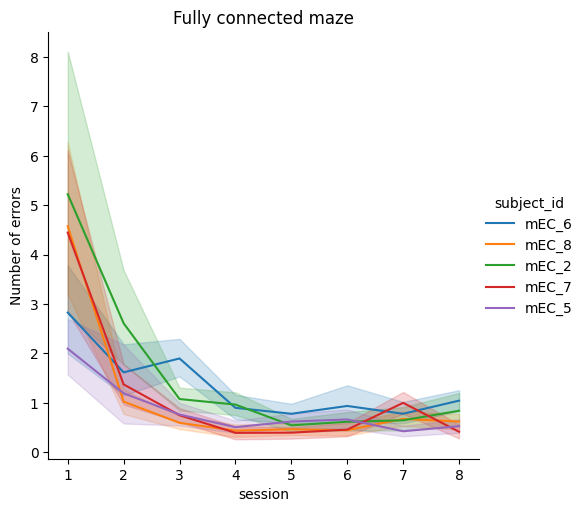

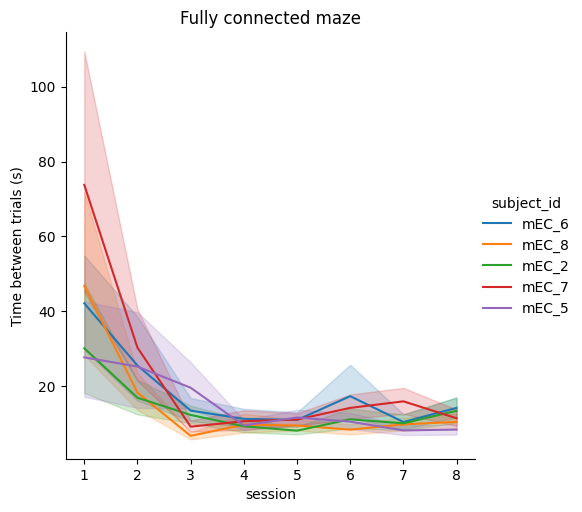

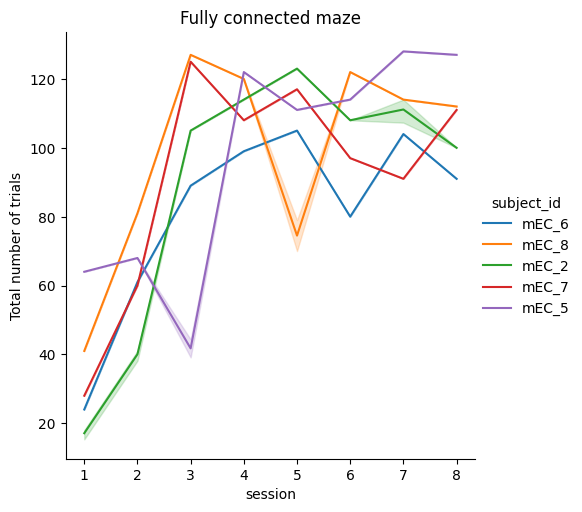

In [168]:
sns.relplot(data=big_trials_DF,
            x='session',
            y='n_errors', 
            hue ='subject_id', 
            kind='line').set(title='Fully connected maze', ylabel='Number of errors')

sns.relplot(data=big_trials_DF,
            x='session',
            y='trial_duration', 
            hue ='subject_id', 
            kind='line').set(title='Fully connected maze', 
                             ylabel='Time between trials (s)')


sns.relplot(data=big_trials_DF,
            x='session',
            y='total_trials',  
            hue='subject_id',
            kind='line').set(title='Fully connected maze', 
                             ylabel='Total number of trials')


In [154]:
big_trials_DF['trial_duration']

0        4.187
1       30.896
2       12.490
3       35.419
4       37.261
        ...   
102     10.090
103      4.324
104    102.118
105     20.067
106     14.212
Name: trial_duration, Length: 3731, dtype: float64